In [1]:
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

import pandas as pd
import numpy as np
#Import paths and patients classes
from notebooks.info import path_label, patient
import notebooks.utils as utils
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from matplotlib import pyplot as plt

In [2]:
def get_ex_included(budget_path: Path):
    """get excluded features name using the budget CV value

    Args:
        budget_path (Path): path to the csv file with the budget

    Returns:
        sequences: excluded and included features
    """
    # get the name of the features from the budget
    budget = pd.read_csv(budget_path, index_col=0)
    # change name of column
    budget.columns = ['budget']
    # get all features with values greater than 1
    excluded = budget[budget[ 'budget' ] > 1].index
    # get all other names
    included = budget[budget[ 'budget' ] <= 1].index
    
    return excluded, included

def get_features(stype:str, excluded:list):
    """
    return df with features given the segmentation type and excluded features

    Args:
        stype (str): general or focal
        excluded (seq): sequence of excluded features

    Returns:
        pd.DataFrame: df with features
    """
    # get features
    features = pd.read_csv(repo_path / 'data' / 'features' / f'features_all_time{stype}.csv', index_col=0)
    features = features.groupby(by='pat_num', axis=0).mean()
    # remove features in excluded list
    features = features.drop(excluded, axis=1)

    return features

# 1. Traditional pipeline

In [13]:
# experiment HP
stype='G' # segmentation type
label = 'RP' # receptor type (RP, RE, KI67)
# load compatible features
budget_path = repo_path/ 'data' / 'budget' / 'budget_ROI_and_rad.csv'
excluded, _ = get_ex_included(budget_path) # get excluded features due to their budget value
features = get_features(stype, excluded)

n = features.shape[0] # number of patients
p = features.shape[1] # number of features
# feature selection using lasso
print(f'The number of patients (n) is: {n}\nThe number of features (p) is: {p}')
# load info class
info = path_label()

The number of patients (n) is: 33
The number of features (p) is: 100


The number of features selected is: 6


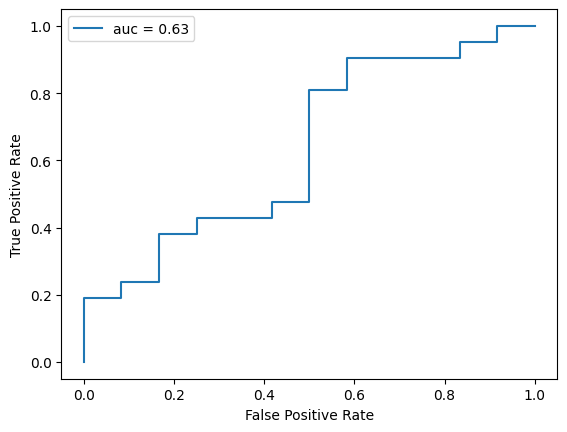

In [27]:
# create loo using kfold
kfold = KFold(n_splits=n)
# prepare data
y = np.asarray(info.labels_list(label))
x = np.asarray(features)

# 1. LASSO
lasso = Pipeline([('scaler', StandardScaler()), ('lasso', LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C=1, max_iter=1000))])
lasso.fit(x, y)
# get the coefficients
coef = lasso.named_steps['lasso'].coef_
features_selected = features.columns[coef[0] != 0]
print(f'The number of features selected is: {len(features_selected)}')

filteres_features = features[features_selected]
x = np.asarray(filteres_features)

# create pipeline with scaler and logistic regression
pipe = Pipeline([('scaler', StandardScaler()), ('lasso', LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', max_iter=1000))])

prob_matrix = np.zeros(shape=(n, 2))
# go through each fold
for train, test in kfold.split(features, y):
    # fit the lasso
    pipe.fit(x[train], y[train])
    # predict
    prob_matrix[test] = pipe.predict_proba(x[test])

# show results
# get roc curve
fpr, tpr, thresholds = roc_curve(y, prob_matrix[:, 1])
# compute auc
auc = roc_auc_score(y, prob_matrix[:, 1])
# plot roc curve
plt.plot(fpr, tpr, label=f'auc = {auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# 2. Robust testing

In [36]:
# read budget
budget = pd.read_csv(budget_path, index_col=0)
budget_mean = pd.read_csv(repo_path / 'data/budget/budget_mean.csv')
active_budget = budget.T[features_selected] * budget_mean.mean().T[features_selected]
active_budget = active_budget.abs()

In [35]:
# HP
num_samples = 1000
# use ER features
x = features[features_selected]
# probability matrix
prob_mat = np.zeros(shape=(x.shape[0], num_samples, 2))

for train, test in kfold.split(x, y):
    # fit train data
    pipe.fit(x.iloc[train], y[train])
    # get test data
    x_test = x.iloc[test]
    # generate 1000 random samples from a normal distribution using the x_test values as mean and the budget as std
    samples = np.random.normal(x_test, active_budget, size=(num_samples, x_test.shape[1]))
    samples = pd.DataFrame(samples)
    samples.columns = x_test.columns # same column names for the standard scaler
    y_proba = pipe.predict_proba(samples)
    prob_mat[test] = y_proba

# the metrics are computed for each gaussian sample
auc = np.zeros(shape=(num_samples,))
accuracy = np.zeros(shape=(num_samples,))
f1 = np.zeros(shape=(num_samples,))
precision = np.zeros(shape=(num_samples,))
sensitivity = np.zeros(shape=(num_samples,))
specificity = np.zeros(shape=(num_samples,))
mcc = np.zeros(shape=(num_samples,))

for i in range(num_samples):
    # compute accuracy
    auc[i] = roc_auc_score(info.labels_list(label), prob_mat[:,i,:][:, 1])
    # fpr, tpr, thresholds = roc_curve(info.labels_list(label), prob_mat[:,i,:][:, 1])
    # thresholdOpt = best_threshold(fpr, tpr, thresholds)
    # threshold = thresholdOpt
    # # accuracy
    # accuracy[i] = accuracy_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
    # f1[i] = f1_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
    # precision[i] = precision_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
    # sensitivity[i] = recall_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
    # specificity[i] = recall_score(info.labels_list(label), y_pred_proba[:, 1] > threshold, pos_label=0)
    # mcc[i] = matthews_corrcoef(info.labels_list(label), y_pred_proba[:, 1] > threshold)
print(f'The mean AUC is: {auc.mean():.2f} +/- {auc.std():.2f}')


The mean AUC is: 0.58 +/- 0.09


# 3. Robust selection

In [37]:
# Criteria to group features
pcc_value = 0.95

# Compute the pearson correlation coefficient
pcc = features.corr(method='pearson')
# compute absolute value, because we are interested in the magnitude of the correlation, not the sign
pcc = pcc.abs()
# if the value is greater than 0.9 but not exaclty 1, group them
pcc = pcc[(pcc > pcc_value) & (pcc < 1)]
pcc.to_csv('pcc_high.csv')
# go through each column and get the name of the features that are correlated
pcc_names = pcc.apply(lambda x: x.dropna().index.tolist(), axis=1)
pcc_names.to_csv('pcc_names.csv')

# list for the clusters (as lists)
clusters = []

# first example in column
for column in pcc_names.index:
    # check if list is empty
    if not pcc_names[column]: # if empty
        clusters.append([column]) # lone feature
    else: # if not empty
        # make a list including the first feature and all the features that are correlated to it
        connected_features = [column] + pcc_names[column]
        # check if any of the features in connected features are already in a cluster
        for cluster in clusters:
            if any(feature in cluster for feature in connected_features):
                # if so, add all the features to that cluster
                cluster.extend(connected_features)
                break
        else: # if not, create a new cluster
            clusters.append(connected_features)
# remove duplicates
for i, cluster in enumerate(clusters):
    cluster = list(set(cluster))
    clusters[i] = cluster

print(f'The number of clusters is {len(clusters)}')

# select a leader feature for each cluster depending on the budget value
budget = pd.read_csv(budget_path, index_col=0).T
cluster_leaders = []
# example
for cluster in clusters:
    # get the feature with the lowest budget value
    leader = budget[cluster].min().idxmin()
    # add it to the list
    cluster_leaders.append(leader)

print(f'The {len(cluster_leaders)} cluster leaders are: {cluster_leaders}')

# read budget
budget = pd.read_csv(budget_path, index_col=0)
budget_mean = pd.read_csv(repo_path / 'data/budget/budget_mean.csv')
active_budget = budget.T[cluster_leaders] * budget_mean.mean().T[cluster_leaders]
active_budget = active_budget.abs()

The number of clusters is 31
The 31 cluster leaders are: ['shape2D_Elongation', 'shape2D_MaximumDiameter', 'gldm_DependenceNonUniformity', 'shape2D_MinorAxisLength', 'shape2D_PerimeterSurfaceRatio', 'shape2D_Sphericity', 'firstorder_10Percentile', 'firstorder_90Percentile', 'firstorder_Entropy', 'firstorder_RobustMeanAbsoluteDeviation', 'firstorder_Kurtosis', 'firstorder_Maximum', 'firstorder_Minimum', 'firstorder_Range', 'glcm_JointAverage', 'gldm_DependenceEntropy', 'glcm_Idmn', 'glcm_Imc2', 'glcm_JointEntropy', 'glcm_MCC', 'glrlm_RunEntropy', 'glszm_GrayLevelVariance', 'gldm_LargeDependenceLowGrayLevelEmphasis', 'gldm_LowGrayLevelEmphasis', 'glszm_SmallAreaHighGrayLevelEmphasis', 'glrlm_LongRunHighGrayLevelEmphasis', 'glrlm_LongRunLowGrayLevelEmphasis', 'ngtdm_Strength', 'ngtdm_Contrast', 'gldm_SmallDependenceHighGrayLevelEmphasis', 'gldm_SmallDependenceLowGrayLevelEmphasis']


In [45]:
# HP
num_samples = 1000
# use ER features
x = features[cluster_leaders]

# 1. LASSO
lasso = Pipeline([('scaler', StandardScaler()), ('lasso', LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C=1, max_iter=1000))])
lasso.fit(x, y)
# get the coefficients
coef = lasso.named_steps['lasso'].coef_
features_selected = features[cluster_leaders].columns[coef[0] != 0]
print(f'The number of features selected is: {len(features_selected)}')

filteres_features = features[features_selected]
x = filteres_features

# probability matrix
prob_mat = np.zeros(shape=(x.shape[0], num_samples, 2))

for train, test in kfold.split(x, y):
    # fit train data
    pipe.fit(x.iloc[train], y[train])
    # get test data
    x_test = x.iloc[test]
    # generate 1000 random samples from a normal distribution using the x_test values as mean and the budget as std
    samples = np.random.normal(x_test, active_budget[features_selected], size=(num_samples, x_test.shape[1]))
    samples = pd.DataFrame(samples)
    samples.columns = x_test.columns # same column names for the standard scaler
    y_proba = pipe.predict_proba(samples)
    prob_mat[test] = y_proba

# the metrics are computed for each gaussian sample
auc = np.zeros(shape=(num_samples,))
accuracy = np.zeros(shape=(num_samples,))
f1 = np.zeros(shape=(num_samples,))
precision = np.zeros(shape=(num_samples,))
sensitivity = np.zeros(shape=(num_samples,))
specificity = np.zeros(shape=(num_samples,))
mcc = np.zeros(shape=(num_samples,))

for i in range(num_samples):
    # compute accuracy
    auc[i] = roc_auc_score(info.labels_list(label), prob_mat[:,i,:][:, 1])
    # fpr, tpr, thresholds = roc_curve(info.labels_list(label), prob_mat[:,i,:][:, 1])
    # thresholdOpt = best_threshold(fpr, tpr, thresholds)
    # threshold = thresholdOpt
    # # accuracy
    # accuracy[i] = accuracy_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
    # f1[i] = f1_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
    # precision[i] = precision_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
    # sensitivity[i] = recall_score(info.labels_list(label), y_pred_proba[:, 1] > threshold)
    # specificity[i] = recall_score(info.labels_list(label), y_pred_proba[:, 1] > threshold, pos_label=0)
    # mcc[i] = matthews_corrcoef(info.labels_list(label), y_pred_proba[:, 1] > threshold)
print(f'The mean AUC is: {auc.mean():.2f} +/- {auc.std():.2f}')

The number of features selected is: 7
The mean AUC is: 0.55 +/- 0.10
